In [113]:
from femdvr import FEMDVR
from lobatto import GaussLegendreLobatto
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import kron, csr_matrix, diags
from scipy.sparse.linalg import eigsh
%matplotlib widget


[9.         1.50030767 0.88932627 0.6848314  0.61061289 0.61061289
 0.6848314  0.88932627 1.50030767 4.5        1.50030767 0.88932627
 0.6848314  0.61061289 0.61061289 0.6848314  0.88932627 1.50030767
 9.        ]
[[0.11111111 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.66652995 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.12444671 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.46021342 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.      

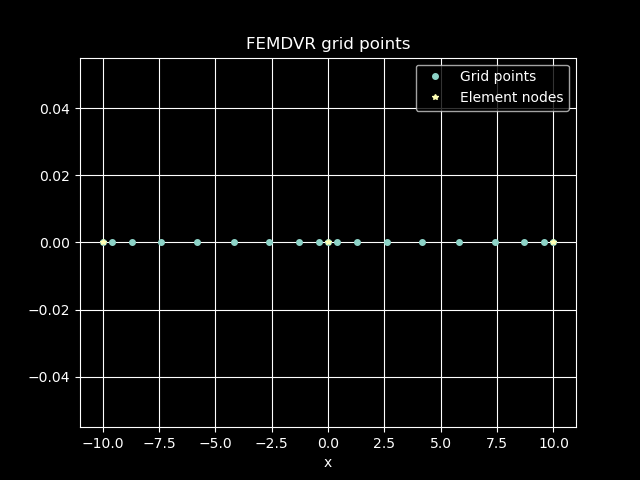

In [120]:
L = 10
n_points = 10
n_elem = 2
elem_nodes = np.linspace(-L, L, n_elem + 1)
femdvr0 = FEMDVR(elem_nodes, np.array([n_points] * n_elem), GaussLegendreLobatto)
x = femdvr0.x
ng = len(x)
x_inner = x[1:-1]

print(1/femdvr0.w)
print(femdvr0.S)
plt.figure()
plt.plot(x, np.zeros_like(x), 'o', markersize=4, label='Grid points')
plt.plot(elem_nodes, np.zeros_like(elem_nodes), '*', markersize=4, label='Element nodes')
plt.title('FEMDVR grid points')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()


Maximum error in first derivative:  0.5094967148251963
Maximum error in second derivative:  0.17313626436342328


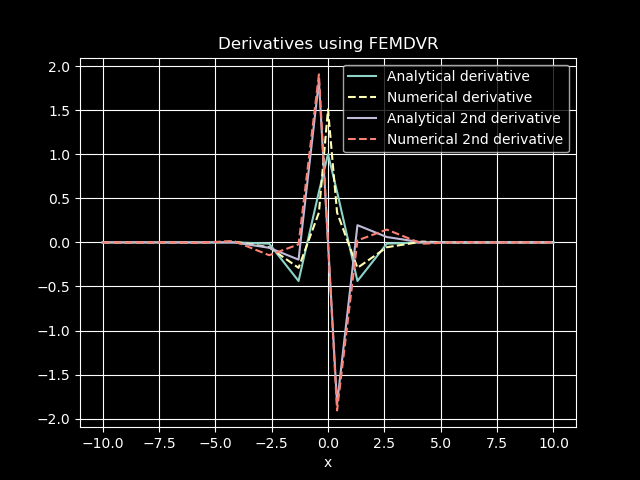

In [121]:
D = femdvr0.D
D2 = femdvr0.D2
f = x * np.exp(-x**2)
dfdx = (1 - 2 * x**2) * np.exp(-x**2)
ddfdx = (4 * x**3 - 6 * x) * np.exp(-x**2)
dfdx_numerical = D @ f
ddfdx_numerical = D2 @ f

error = np.max( np.abs( dfdx - dfdx_numerical ) )
print("Maximum error in first derivative: ", error)

error = np.max( np.abs( ddfdx - ddfdx_numerical ) )
print("Maximum error in second derivative: ", error)

plt.figure()
plt.plot(x, dfdx, label='Analytical derivative')
plt.plot(x, dfdx_numerical, '--', label='Numerical derivative')
plt.plot(x, ddfdx, label='Analytical 2nd derivative')
plt.plot(x, ddfdx_numerical, '--', label='Numerical 2nd derivative')    
plt.title('Derivatives using FEMDVR')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()


Maximum error in first derivative:  0.5094967148251961
Maximum error in second derivative:  0.17313626436342333


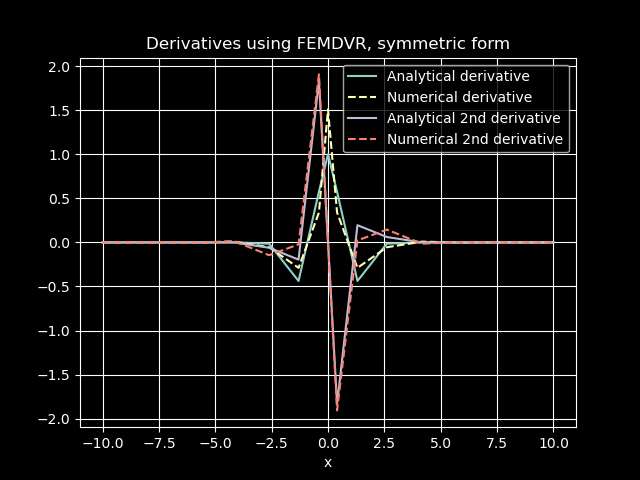

In [122]:
D = femdvr0.D_symmetric
D2 = femdvr0.D2_symmetric
f = x * np.exp(-x**2)
dfdx = (1 - 2 * x**2) * np.exp(-x**2)
ddfdx = (4 * x**3 - 6 * x) * np.exp(-x**2)

# Numerical derivatives in symmetric form. Note the mass matrix factors.
dfdx_numerical =  femdvr0.S_inv_sqrt * (D @ (femdvr0.S_sqrt * f))
ddfdx_numerical =  femdvr0.S_inv_sqrt * (D2 @ (femdvr0.S_sqrt * f))

error = np.max( np.abs( dfdx - dfdx_numerical ) )
print("Maximum error in first derivative: ", error)

error = np.max( np.abs( ddfdx - ddfdx_numerical ) )
print("Maximum error in second derivative: ", error)

plt.figure()
plt.plot(x, dfdx, label='Analytical derivative')
plt.plot(x, dfdx_numerical, '--', label='Numerical derivative')
plt.plot(x, ddfdx, label='Analytical 2nd derivative')
plt.plot(x, ddfdx_numerical, '--', label='Numerical 2nd derivative')    
plt.title('Derivatives using FEMDVR, symmetric form')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()

Maximum error in Poisson problem:  1.4378823465222013e-08


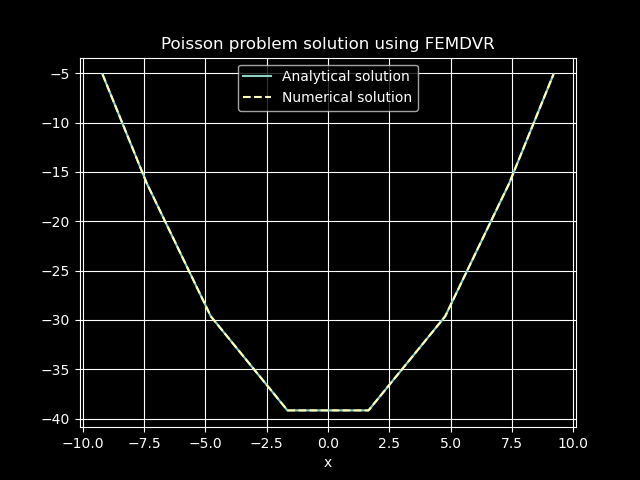

In [117]:
# Set up a poisson problem

f = np.cos( np.pi * x_inner / (2*L) )
u_exact = - (L**2 / (np.pi**2 / 4)) * np.cos( np.pi * x_inner / (2*L) )

D2_inner = femdvr0.D2[1:-1, 1:-1]
u_numerical =  np.linalg.solve( D2_inner.toarray(), f )
error = np.max( np.abs( u_exact - u_numerical ) )
print("Maximum error in Poisson problem: ", error)

plt.figure()
plt.plot(x_inner, u_exact, label='Analytical solution')
plt.plot(x_inner, u_numerical, '--', label='Numerical solution')
plt.title('Poisson problem solution using FEMDVR')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()

Maximum error in Poisson problem:  9.379164112033322e-13


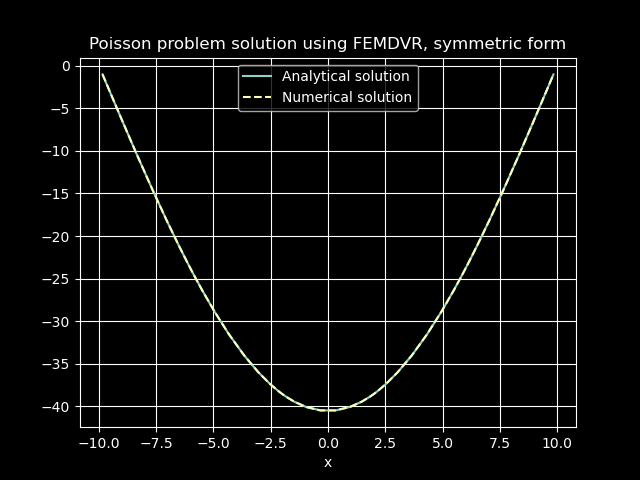

In [51]:
# Set up a poisson problem, symmetric form

f = np.cos( np.pi * x_inner / (2*L) )
u_exact = - (L**2 / (np.pi**2 / 4)) * np.cos( np.pi * x_inner / (2*L) )

D2_symmetric_inner = femdvr0.D2_symmetric[1:-1, 1:-1]

u_numerical = femdvr0.S_inv_sqrt[1:-1] *  np.linalg.solve( D2_symmetric_inner.toarray(), femdvr0.S_sqrt[1:-1] * f )
error = np.max( np.abs( u_exact - u_numerical ) )
print("Maximum error in Poisson problem: ", error)

plt.figure()
plt.plot(x_inner, u_exact, label='Analytical solution')
plt.plot(x_inner, u_numerical, '--', label='Numerical solution')
plt.title('Poisson problem solution using FEMDVR, symmetric form')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()

In [87]:
def poisson_experiment(L, n_elem, n_points):
    """ Solve a simple poisson equation using FEMDVR and return error."""

    elem_nodes = np.linspace(-L, L, n_elem + 1)
    femdvr0 = FEMDVR(elem_nodes, np.array([n_points] * n_elem), GaussLegendreLobatto)
    x = femdvr0.x
    x_inner = x[1:-1]

    f = np.cos( np.pi * x_inner / (2*L) )
    u_exact = - (L**2 / (np.pi**2 / 4)) * np.cos( np.pi * x_inner / (2*L) )

    D2_symmetric_inner = femdvr0.D2_symmetric[1:-1, 1:-1]

    u_numerical = femdvr0.S_inv_sqrt[1:-1] *  np.linalg.solve( D2_symmetric_inner.toarray(), femdvr0.S_sqrt[1:-1] * f )
    #error = np.max( np.abs( u_exact - u_numerical ) )
    error = np.linalg.norm( u_exact - u_numerical )
    #print(f"L={L}, n_elem={n_elem}, n_points={n_points}, max error: {error}")
    return error

In [88]:
n_elem_list = list(range(2, 44, 2))
n_points_list = list(range(3, 15, 2))
errors = np.zeros( (len(n_elem_list), len(n_points_list)) )
from itertools import product
for i in range(len(n_elem_list)):
    for j in range(len(n_points_list)):
        n_elem = n_elem_list[i]
        n_points = n_points_list[j]
        errors[i, j] = poisson_experiment(10, n_elem, n_points)

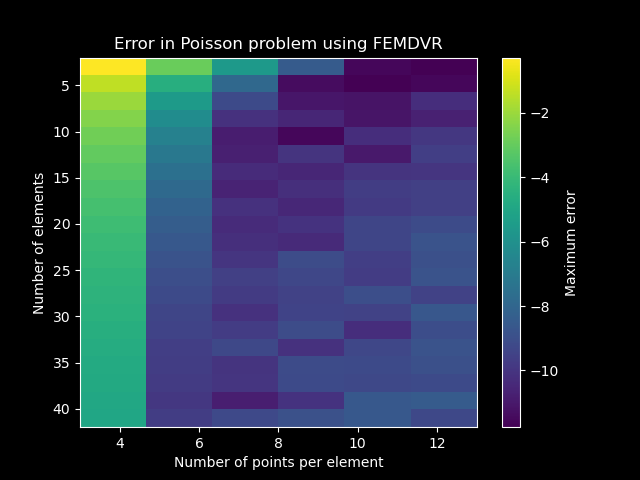

In [89]:
plt.figure()
plt.imshow(np.log10(errors), extent=[min(n_points_list), max(n_points_list), max(n_elem_list), min(n_elem_list)], aspect='auto')
plt.colorbar(label='Maximum error')
plt.xlabel('Number of points per element')
plt.ylabel('Number of elements')
plt.title('Error in Poisson problem using FEMDVR')
plt.show()

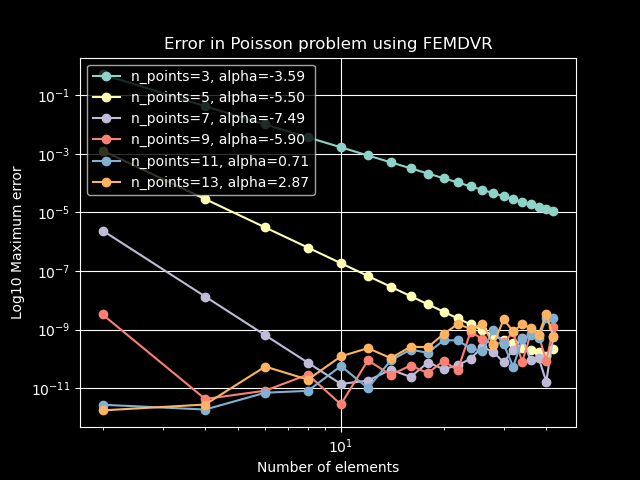

In [92]:

plt.figure()

for i in range(len(n_points_list)):
    n_points = n_points_list[i]
    alpha = np.polyfit( np.log(n_elem_list[:3]), np.log(errors[:3, i]), 1)[0]
    plt.loglog(n_elem_list, errors[:, i], label=f'n_points={n_points}, alpha={alpha:.2f}', marker='o')
plt.xlabel('Number of elements')
plt.ylabel('Log10 Maximum error')
plt.title('Error in Poisson problem using FEMDVR')
plt.grid()
plt.legend()
plt.show()